In [ ]:
!git clone https://github.com/wkcn/TinyViT.git tiny_vit_repo
!git clone https://github.com/facebookresearch/ConvNeXt.git convnext_repo

!curl -L -o imagenet1k-val.zip\
  https://www.kaggle.com/api/v1/datasets/download/titericz/imagenet1k-val

!unzip -q imagenet1k-val.zip -d val/

fatal: destination path 'tiny_vit_repo' already exists and is not an empty directory.
Cloning into 'convnext_repo'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 252 (delta 100), reused 80 (delta 80), pack-reused 113 (from 3)
Receiving objects: 100% (252/252), 76.71 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (127/127), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6362M  100 6362M    0     0  93.4M      0  0:01:08  0:01:08 --:--:--  117M


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import numpy as np

In [ ]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [ ]:
import sys
sys.path.append('tiny_vit_repo')

from models import tiny_vit  # model file is under tiny_vit_repo/models/tiny_vit.py
import torch

vit = tiny_vit.tiny_vit_21m_224(pretrained=False)

checkpoint = torch.load('tiny_vit_21m_22kto1k_distill.pth', map_location='cpu')
vit.load_state_dict(checkpoint['model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = vit.to(device)
vit.eval()

print("TinyViT loaded successfully.")

TinyViT loaded successfully.


In [ ]:
import sys
import importlib

if 'models' in sys.modules:
    del sys.modules['models']
if 'tiny_vit_repo' in sys.path:
  sys.path.remove('tiny_vit_repo')
sys.path.append('convnext_repo')
from models import convnext
import torch

convnext = convnext.convnext_tiny(num_classes=1000)

checkpoint = torch.load('convnext_tiny_22k_1k_224.pth', map_location='cpu')
convnext.load_state_dict(checkpoint['model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
convnext = convnext.to(device)
convnext.eval()

print("ConvNeXt-Tiny loaded successfully.")

/content/convnext_repo/models/convnext.py:158: UserWarning: Overwriting convnext_tiny in registry with models.convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/convnext_repo/models/convnext.py:167: UserWarning: Overwriting convnext_small in registry with models.convnext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/convnext_repo/models/convnext.py:176: UserWarning: Overwriting convnext_base in registry with models.convnext.convnext_base. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/convnext_repo/models/convnext.py:185: UserWarning: Overwriting convnext_large in registry with models.convnext.convnext_large. This is because the name being registered conflicts with an existin

ConvNeXt-Tiny loaded successfully.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = timm.create_model(
    'hf-hub:timm/resnetv2_50x1_bit.goog_in21k_ft_in1k',
    pretrained=True
)

resnet = resnet.to(device)
resnet.eval()

print("ResNetV2-50x1 loaded successfully.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ResNetV2-50x1 loaded successfully.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
res_transform = transforms.Compose([
    transforms.Resize(448),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
])
# Load the dataset
val_dataset = datasets.ImageFolder('val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

def update(frame):
    ax.clear()
    act = activations[frame]
    layer = layer_names[frame]
    ax.set_title(f"Layer: {layer}")

    if layer == 'head':
        probs = torch.nn.functional.softmax(torch.tensor(act), dim=0).numpy()
        topk = np.argsort(probs)[-10:][::-1]
        labels = [imagenet_classes[i] for i in topk]
        values = probs[topk]
        ax.barh(labels[::-1], values[::-1])  # reverse for top-down
        ax.set_xlim(0, 1.0)

    elif act.ndim == 2:
        img = ax.imshow(act, cmap='viridis')
    else:
        img = ax.bar(np.arange(len(act)), act)
        ax.set_ylim(0, np.max(act) + 1)

    return ax

def get_hook(name):
    def hook_fn(module, input, output):
        with torch.no_grad():
            if output.dim() == 4:  # [B,C,H,W]
                act = output[0].mean(0).cpu().numpy()
            elif output.dim() == 3:  # [B,N,C]
                act = output.mean(dim=1)[0].cpu().numpy()  # average over tokens
            elif output.dim() == 2:  # [B, num_classes]
                act = output[0].cpu().numpy()  # logits
            else:
                act = np.zeros((1,))
            features[name] = act
    return hook_fn

In [ ]:
import torch
from tqdm import tqdm

resnet.to(device)
vit.to(device)
convnext.to(device)
original_image_path = val_dataset.imgs[0][0]
original_image = Image.open(original_image_path).convert('RGB')
img = Image.open(original_image_path).convert('RGB')

def get_prediction(model, image):
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

for idx, (image, label) in enumerate(tqdm(val_loader)):
    image = image.to(device)
    label = label.to(device)
    res_image = res_transform(img).unsqueeze(0).to(device)
    pred_resnet = get_prediction(resnet, res_image)
    pred_tiny_vit = get_prediction(vit, image)
    pred_convnext = get_prediction(convnext, image)

    if (pred_resnet != label.item()) and (pred_tiny_vit == label.item()) and (pred_convnext == label.item()):
        print(f"Found suitable image at index: {idx}")
        break


  0%|          | 0/50000 [00:01<?, ?it/s]

Found suitable image at index: 0


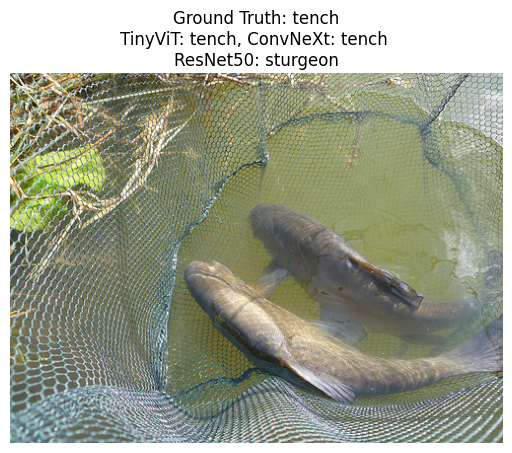

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

original_image_path = val_dataset.imgs[0][0]
original_image = Image.open(original_image_path).convert('RGB')
gt_label = imagenet_classes[label.item()]
resnet_label = imagenet_classes[pred_resnet]
tinyvit_label = imagenet_classes[pred_tiny_vit]
convnext_label = imagenet_classes[pred_convnext]

plt.imshow(original_image)
plt.title(f"Ground Truth: {gt_label}\nTinyViT: {tinyvit_label}, ConvNeXt: {convnext_label} \nResNet50: {resnet_label}")
plt.axis('off')
plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

img = Image.open(original_image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

features = {}
hook_layers = {
    'patch_embed': vit.patch_embed.seq[0],
    'layer0': vit.layers[0].blocks[0],
    'layer1': vit.layers[1].blocks[0],
    'layer2': vit.layers[2].blocks[0],
    'head': vit.head
}


for name, layer in hook_layers.items():
    layer.register_forward_hook(get_hook(name))

_ = vit(input_tensor)

frames = [features[name] for name in hook_layers.keys()]
titles = list(hook_layers.keys())

fig, ax = plt.subplots()
layer_names = titles
activations = frames

ani = animation.FuncAnimation(fig, update, frames=len(activations), interval=1000, blit=False)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
features = {}
hook_layers = {
    'stem': resnet.stem[0],
    'stage1': resnet.stages[0].blocks[0],
    'stage2': resnet.stages[1].blocks[0],
    'stage3': resnet.stages[2].blocks[0],
    'stage4': resnet.stages[3].blocks[0],
    'head': resnet.head
}

for name, layer in hook_layers.items():
    layer.register_forward_hook(get_hook(name))

input_tensor = res_transform(img).unsqueeze(0).to(device)
_ = resnet(input_tensor)

frames = [features[name] for name in hook_layers.keys()]
titles = list(hook_layers.keys())

fig, ax = plt.subplots()
layer_names = titles
activations = frames

ani = animation.FuncAnimation(fig, update, frames=len(activations), interval=1000, blit=False)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
features = {}
hook_layers = {
    'stem': convnext.downsample_layers[0][0],
    'stage1': convnext.stages[0][0],
    'stage2': convnext.stages[1][0],
    'stage3': convnext.stages[2][0],
    'stage4': convnext.stages[3][0],
    'head': convnext.head
}

for name, layer in hook_layers.items():
    layer.register_forward_hook(get_hook(name))

input_tensor = transform(img).unsqueeze(0).to(device)
_ = convnext(input_tensor)

frames = [features[name] for name in hook_layers.keys()]
layer_names = list(hook_layers.keys())
activations = frames

fig, ax = plt.subplots()

ani = animation.FuncAnimation(fig, update, frames=len(activations), interval=1000, blit=False)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())